In [1]:
import numpy as np
import pandas as pd

import fatf
import fatf.utils.data.datasets as fatf_datasets
from sklearn.neural_network import MLPClassifier as NN
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

import itertools as it
from supp import sample
# Fix random seed
fatf.setup_random_seed(42)

21-Nov-02 22:20:31 fatf         INFO     Seeding RNGs using the input parameter.
21-Nov-02 22:20:31 fatf         INFO     Seeding RNGs with 42.


In [2]:
def filter_keys(index, value, d):
    return [
        key
        for key in d.keys()
        if key[index] == value
    ]

In [14]:
def get_df(out, index, value, radii):
    df = pd.DataFrame(
        {k: v for k, v in out[key].items() if k not in ['surrogate']}
        for key in filter_keys(index, value, out)
    )
    df.set_index(radii, inplace=True)
    return df

def _plot(df, radii):
    n_ftrs = len(df.columns)
    fig, axes = plt.subplots(ncols=1, nrows=n_ftrs, figsize=(20, n_ftrs*3), sharex=True)
    for idx, col in enumerate(df.columns):
        ax=axes[idx]
        if col in ['fis']:
            ndf = pd.DataFrame(df['fis'].to_list())
            ndf.set_index(radii, inplace=True)
            ndf.plot(ax=ax)
        else:
            df[col].plot(ax=ax)

        ax.set_title(col)
        
def make_plot(out, index, value, radii):
    df = get_df(out, index, value, radii)
    _plot(df, radii)

In [3]:

# Load data
iris_data_dict = fatf_datasets.load_iris()
iris_X = iris_data_dict['data']
iris_y = iris_data_dict['target']
iris_feature_names = iris_data_dict['feature_names'].tolist()
iris_class_names = iris_data_dict['target_names'].tolist()

# Train a model
# clf = fatf_models.KNN()
clf = NN(max_iter=5000)
clf.fit(iris_X, iris_y)

MLPClassifier(max_iter=5000)

In [25]:
def get_explainers(x, predict_fn, surrogate_model, kwargs_list, attributes, radii):
    surrogates = {}
    for r in radii:
        sample_x = sample(x, r, 5000)
        sample_y = predict_fn(sample_x)
        
        for kwargs in kwargs_list:
            surrogate = surrogate_model(**kwargs).fit(sample_x, sample_y)
            out = {
                'surrogate': surrogate,
                'score': surrogate.score(sample_x, sample_y),
            }
            
            for attr_name, attr in attributes.items():
                out[attr_name] = attr(surrogate)
                
            surrogates[tuple([r]+list(kwargs.values()))] = out
    return surrogates

In [26]:
complexity_attributes = {
    'depth': lambda x: x.get_depth(),
    'n_leaves': lambda x: x.get_n_leaves(),
    'fis': lambda x: x.feature_importances_,
}

parameters = {
    'max_depth': [3, 4, 5],
}

radii = np.linspace(1.5, 2, 10)

kwargs_list = [
    dict(zip(parameters.keys(), _tuple))
    for _tuple in it.product(*parameters.values())
]


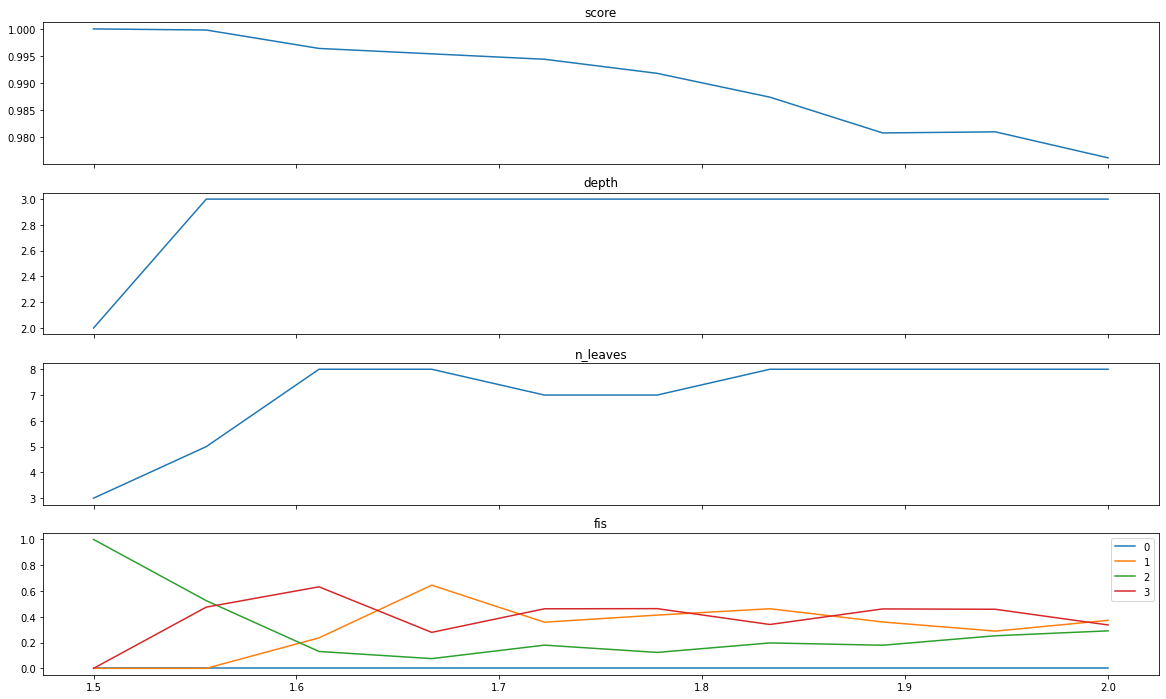

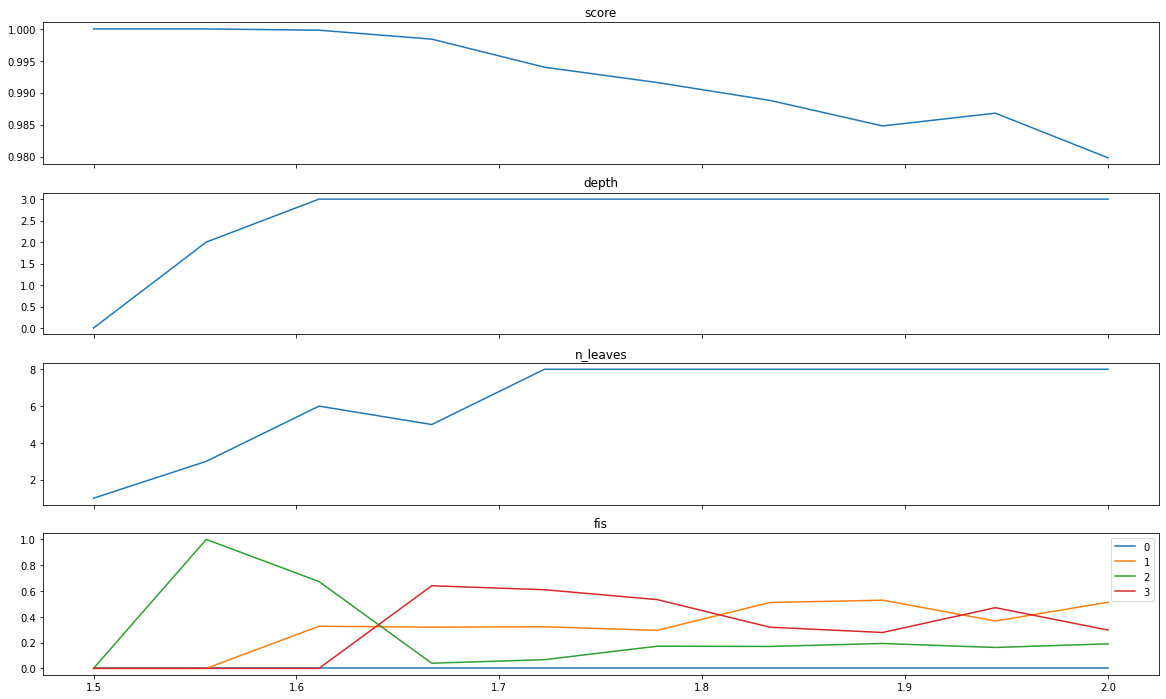

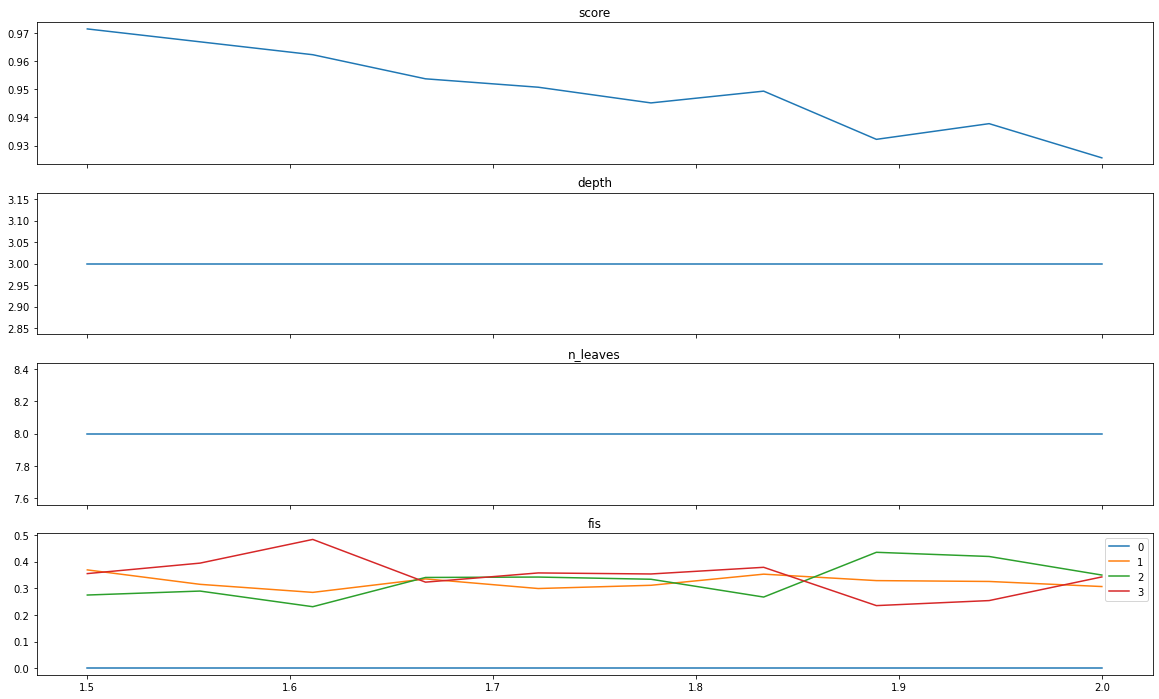

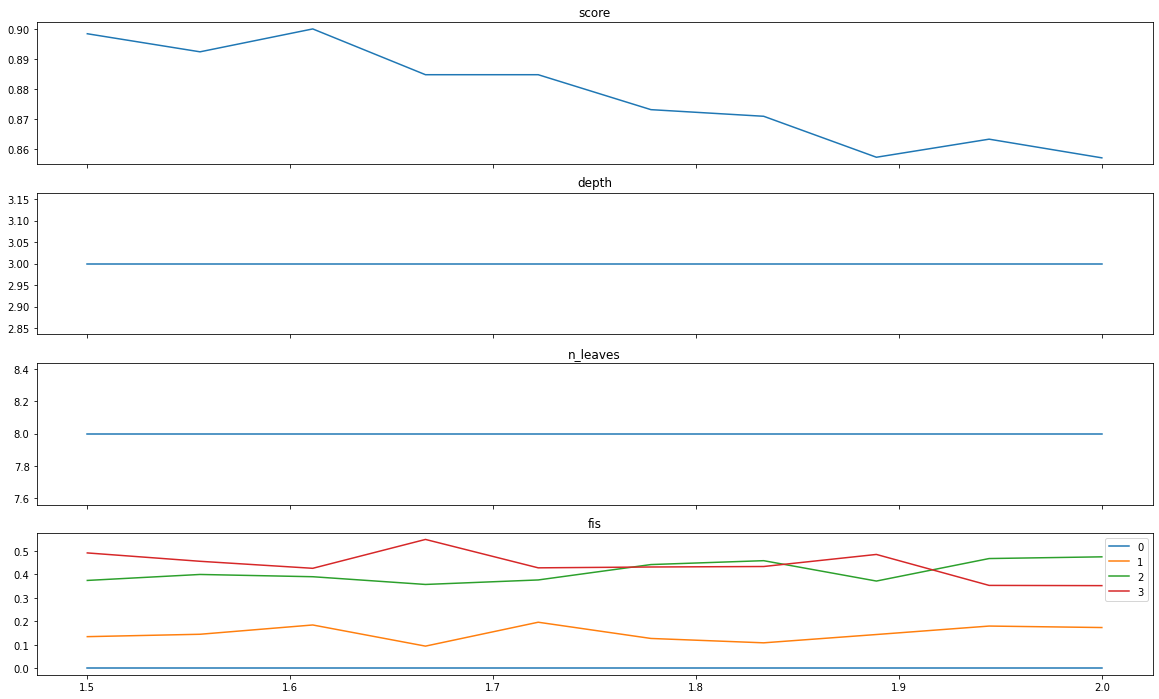

In [29]:
for idx in [0, 10, 25, 50]:
    subject = iris_X[[idx], :]

    out = get_explainers(
        subject,
        clf.predict,
        DecisionTreeClassifier,
        kwargs_list,
        complexity_attributes,
        radii
    )

    make_plot(out, 1, 3, radii)